In [39]:
import torch
from torch import nn

device = "cuda" #if torch.cuda.is_available() else "cpu"
device

'cuda'

In [40]:
import os

train_dir = "/home/uam/HamdahM/training_set"
test_dir = "/home/uam/HamdahM/test_set"
train_dir, test_dir

('/home/uam/HamdahM/training_set', '/home/uam/HamdahM/test_set')

In [41]:
image_path = "/home/uam/HamdahM"

Random image path: /home/uam/HamdahM/training_set/dogs/dog.2467.jpg
Image class: dogs
Image height: 210
Image width: 359


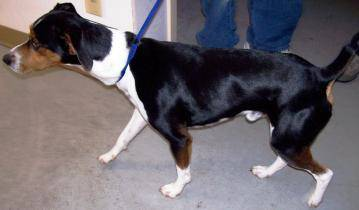

In [42]:
import random
from PIL import Image
import glob
from pathlib import Path

# Set seed
random.seed(42) 

# 1. Get all image paths (* means "any combination")
image_path_list= glob.glob(f"{image_path}/*/*/*.jpg")

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = Path(random_image_path).parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img


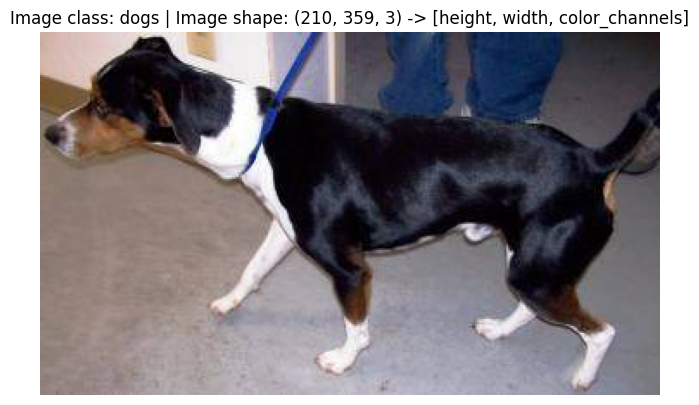

In [43]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [44]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to IMAGE_SIZE xIMAGE_SIZE 
    transforms.Resize(size=IMAGE_SIZE),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

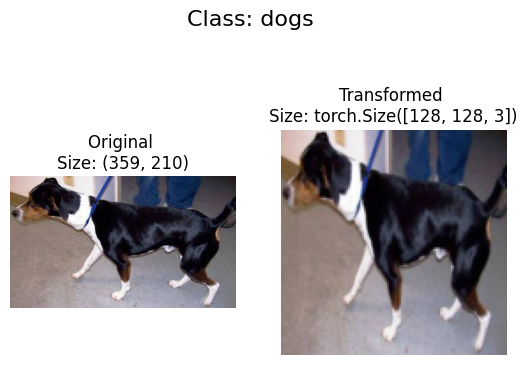

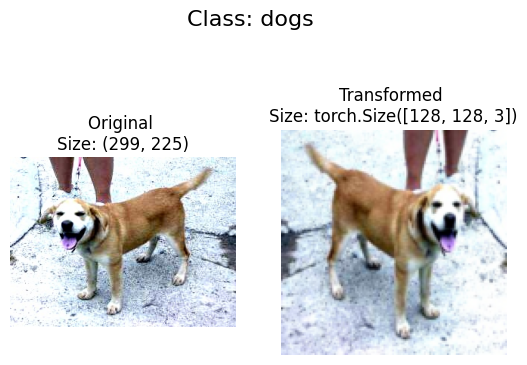

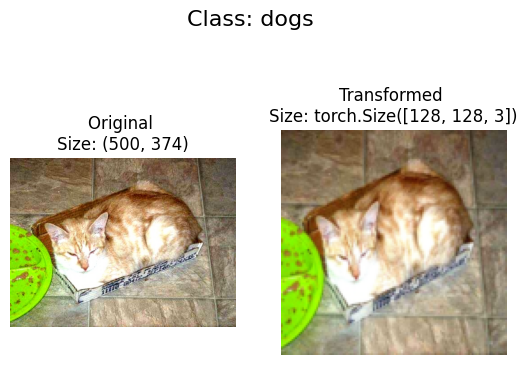

In [45]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            fig.suptitle(f"Class: {Path(random_image_path).parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, transform=data_transform, n=3)

In [46]:
from torchvision import datasets

# Creating training set
train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform, 
                                  target_transform=None) 
#Creating test set
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 8005
    Root location: /home/uam/HamdahM/training_set
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2023
    Root location: /home/uam/HamdahM/test_set
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [47]:
class_names = train_data.classes
class_dict = train_data.class_to_idx

Original shape: torch.Size([3, 128, 128]) -> [color_channels, height, width]
Image permute shape: torch.Size([128, 128, 3]) -> [height, width, color_channels]


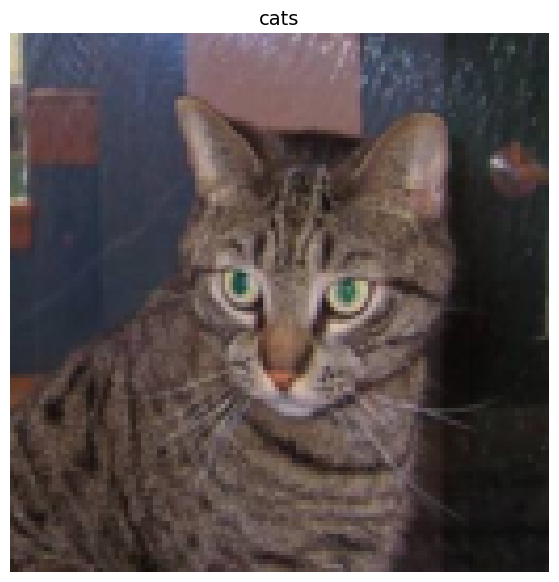

In [48]:
img, label = train_data[0][0], train_data[0][1]
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

In [49]:
from torch.utils.data import DataLoader

# How many subprocesses will be used for data loading (higher = more)
NUM_WORKERS = os.cpu_count()

# Turn train and test Datasets into DataLoaders
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=NUM_WORKERS,
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=NUM_WORKERS, 
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f56b04a0c10>,
 <torch.utils.data.dataloader.DataLoader at 0x7f5689f90af0>)

In [50]:
img, label = next(iter(train_dataloader))

# Set image size.
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.TrivialAugmentWide(),
    transforms.ToTensor()])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor()])

In [51]:
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform)
test_data_augmented = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_augmented

(Dataset ImageFolder
     Number of datapoints: 8005
     Root location: /home/uam/HamdahM/training_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2023
     Root location: /home/uam/HamdahM/test_set
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [52]:
BATCH_SIZE = 32
torch.manual_seed(42)

train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_augmented = DataLoader(test_data_augmented, 
                                       batch_size=BATCH_SIZE, 
                                       shuffle=False, 
                                       num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x7f56b04a3d30>,
 <torch.utils.data.dataloader.DataLoader at 0x7f56b04a2920>)

In [53]:
import torch
import torch.nn as nn


class ImageClassifierv2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer_1 = nn.Sequential(
          nn.Conv2d(3, 64, 3, padding=1),
          nn.ReLU(),
          nn.BatchNorm2d(64),
          nn.MaxPool2d(2))
        self.conv_layer_2 = nn.Sequential(
          nn.Conv2d(64, 128, 3, padding=1),  # Reduced to 128 from 512
          nn.ReLU(),
          nn.BatchNorm2d(128),
          nn.MaxPool2d(2))
        self.conv_layer_3 = nn.Sequential(
          nn.Conv2d(128, 256, 3, padding=1),  # New layer for gradual increase
          nn.ReLU(),
          nn.BatchNorm2d(256),
          nn.MaxPool2d(2))
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # Global Avg Pooling
        self.classifier = nn.Sequential(
          nn.Flatten(),
          nn.Dropout(0.5),  # Added dropout
          nn.Linear(in_features=256, out_features=2))

    def forward(self, x: torch.Tensor):
        x = self.conv_layer_1(x)
        x = self.conv_layer_2(x)
        x = self.conv_layer_3(x)
        x = self.global_avg_pool(x)  # Replace flattening with GAP
        x = self.classifier(x)
        return x

model = ImageClassifierv2().to(device)

In [54]:
img_batch, label_batch = next(iter(train_dataloader_augmented))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 224, 224])

Output logits:
tensor([[0.0322, 0.0211]], device='cuda:0')

Output prediction probabilities:
tensor([[0.5028, 0.4972]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
0


In [55]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               adv_lr = 1e-3):
    # Put model in train mode
    
    
    model.train()
    
    # Setup train loss and train accuracy values
    adv_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        
        mu = X.mean(dim=[2, 3], keepdim=True)
        var = X.var(dim=[2, 3], keepdim=True)
        sig = (var + 1e-5).sqrt()
        mu, sig = mu.detach(), sig.detach()
        input_normed = (X - mu) / sig
        input_normed = input_normed.detach().clone()
        # Set learnable style feature and adv optimizer
        adv_mu, adv_sig = mu, sig
        adv_mu.requires_grad_(True)
        adv_sig.requires_grad_(True)
        adv_optim = torch.optim.SGD(params=[adv_mu, adv_sig], lr=adv_lr, momentum=0, weight_decay=0)
        # Optimize adversarial style feature
        adv_optim.zero_grad()
        adv_input = input_normed * adv_sig+ adv_mu
        adv_output = model(adv_input)
        adv_loss = torch.nn.functional.cross_entropy(adv_output, y)
        (- adv_loss).backward()
        adv_optim.step()
        


        optimizer.zero_grad()
        adv_input = input_normed * adv_sig + adv_mu
        inputs = torch.cat((X, adv_input), dim=0)
        gt = torch.cat((y, y), dim=0)
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, gt)
        loss.backward()
        optimizer.step()

        # 1. Forward pass
        #y_pred = model(X)

        #loss = loss_fn(y_pred, y)
        #train_loss += loss.item() 

        # 3. Optimizer zero grad
        #optimizer.zero_grad()

        # 4. Loss backward
        #loss.backward()

        # 5. Optimizer step
        #optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(adv_output, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(adv_output)

    adv_loss = adv_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return adv_loss, train_acc

In [56]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [57]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [58]:
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 10

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model,
                      train_dataloader=train_dataloader_augmented,
                      test_dataloader=test_dataloader_augmented,
                      optimizer=optimizer,
                      loss_fn=loss_fn,
                      epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0017 | train_acc: 0.5823 | test_loss: 0.6673 | test_acc: 0.6080
Epoch: 2 | train_loss: 0.0029 | train_acc: 0.6125 | test_loss: 0.6332 | test_acc: 0.6295
Epoch: 3 | train_loss: 0.0023 | train_acc: 0.6259 | test_loss: 0.6472 | test_acc: 0.6016
Epoch: 4 | train_loss: 0.0025 | train_acc: 0.6327 | test_loss: 0.6072 | test_acc: 0.6732
Epoch: 5 | train_loss: 0.0018 | train_acc: 0.6589 | test_loss: 0.5754 | test_acc: 0.6952
Epoch: 6 | train_loss: 0.0025 | train_acc: 0.6685 | test_loss: 0.5624 | test_acc: 0.7040
Epoch: 7 | train_loss: 0.0031 | train_acc: 0.6828 | test_loss: 0.5867 | test_acc: 0.6932
Epoch: 8 | train_loss: 0.0013 | train_acc: 0.6933 | test_loss: 0.5257 | test_acc: 0.7306
Epoch: 9 | train_loss: 0.0028 | train_acc: 0.7082 | test_loss: 0.5329 | test_acc: 0.7416
Epoch: 10 | train_loss: 0.0021 | train_acc: 0.7187 | test_loss: 0.4915 | test_acc: 0.7692
Total training time: 796.695 seconds


In [59]:
def plot_loss_curves(results):
  
    results = dict(list(model_results.items()))

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plot_loss_curves(model_results)

In [60]:
# Choose a image.
custom_image_path = "/home/uam/HamdahM/test_set/cats/cat.4017.jpg"

import torchvision
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.7020, 0.8000, 0.5686,  ..., 0.2941, 0.3098, 0.3059],
         [0.7686, 0.6314, 0.6549,  ..., 0.3137, 0.3412, 0.2745],
         [0.6706, 0.7216, 0.7176,  ..., 0.3137, 0.2275, 0.3020],
         ...,
         [0.5647, 0.5647, 0.5686,  ..., 0.2000, 0.2000, 0.1882],
         [0.5608, 0.5608, 0.5608,  ..., 0.1765, 0.1922, 0.1765],
         [0.5569, 0.5529, 0.5529,  ..., 0.1843, 0.2118, 0.1882]],

        [[0.7059, 0.8039, 0.5725,  ..., 0.2980, 0.3137, 0.3098],
         [0.7725, 0.6353, 0.6588,  ..., 0.3176, 0.3451, 0.2784],
         [0.6745, 0.7255, 0.7216,  ..., 0.3176, 0.2314, 0.3059],
         ...,
         [0.5255, 0.5255, 0.5294,  ..., 0.1961, 0.1961, 0.1843],
         [0.5216, 0.5216, 0.5216,  ..., 0.1725, 0.1882, 0.1725],
         [0.5176, 0.5137, 0.5137,  ..., 0.1804, 0.2078, 0.1843]],

        [[0.7882, 0.8863, 0.6510,  ..., 0.3059, 0.3216, 0.3176],
         [0.8549, 0.7176, 0.7373,  ..., 0.3255, 0.3529, 0.2863],
         [0.7569, 0.8078, 0.8000,  ..

In [61]:
custom_image_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 200, 105])
New shape: torch.Size([3, 224, 224])


In [62]:
model.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 224, 224])
Unsqueezed custom image shape: torch.Size([1, 3, 224, 224])


In [63]:
custom_image_pred

tensor([[ 0.8058, -0.6117]], device='cuda:0')

In [64]:

print(f"Prediction logits: {custom_image_pred}")

custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.8058, -0.6117]], device='cuda:0')
Prediction probabilities: tensor([[0.8049, 0.1951]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


In [65]:
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'cats'

(-0.5, 104.5, 199.5, -0.5)

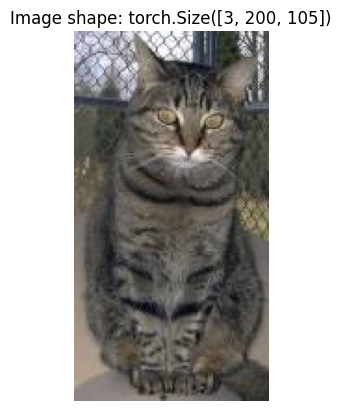

In [66]:
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False)

In [67]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image


In [68]:
model.eval()

image_path = "/home/uam/HamdahM/test_set/cats/cat.4017.jpg"

custom_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

custom_image = custom_image / 255

custom_image_transformed = custom_image_transform(custom_image)



In [69]:
custom_image_transformed.requires_grad = True
output = model(custom_image_transformed.unsqueeze(dim=0).to(device))
predicted_label = torch.argmax(output, 1).item()
predicted_label

0

In [70]:
true_label = torch.tensor([0]).to(device)

loss = torch.nn.CrossEntropyLoss()(output, true_label)

In [71]:
model.zero_grad()
loss.backward()
data_grad = custom_image_transformed.grad.data

In [72]:
epsilon = 0.125
perturbed_image = fgsm_attack(custom_image_transformed, epsilon, data_grad)

In [73]:
output = model(perturbed_image.unsqueeze(dim=0).to(device))
new_predicted_label = torch.argmax(output, 1).item()

In [74]:
image_np = np.transpose(custom_image_transformed.squeeze().detach().numpy(), (1, 2, 0))
perturbed_image_np = np.transpose(perturbed_image.squeeze().detach().numpy(), (1, 2, 0))

In [75]:
def show_image_label(image, label):
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    plt.show()

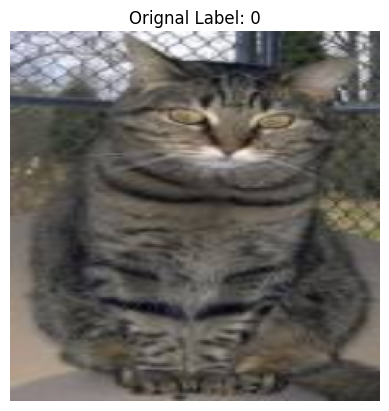

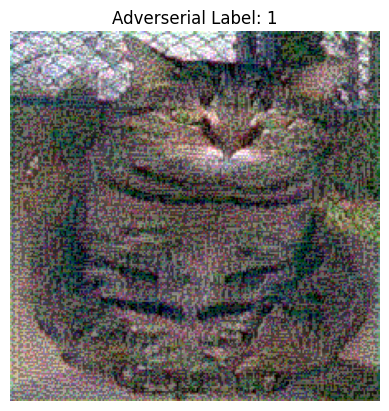

In [76]:
show_image_label(image_np, f"Orignal Label: {predicted_label}")
show_image_label(perturbed_image_np, f"Adverserial Label: {new_predicted_label}")